## 1. Importar Librerías

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
sys.path.insert(0, str(project_root))

import torch
import matplotlib.pyplot as plt
from src.finetuning.dataset import get_data_loaders
from src.finetuning.models import get_model, count_parameters
from src.finetuning.trainer import Trainer
from src.logger_cfg.setup import setup_logging

# Setup logging
logger = setup_logging()

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070


## 2. Configuración

In [5]:
# Configuración de datos
DATA_DIR = '../data/processed/equipment_classification'
BATCH_SIZE = 32
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1
NUM_WORKERS = 4
SEED = 42

# Configuración de modelo
MODEL_TYPE = 'resnet50'  # 'resnet50' o 'inception_v3'
PRETRAINED = True
FREEZE_BACKBONE = False

# Configuración de entrenamiento
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
EARLY_STOPPING = 10
CHECKPOINT_DIR = f'models/equipment_classification/{MODEL_TYPE}'

# Input size basado en el modelo
INPUT_SIZE = 299 if MODEL_TYPE == 'inception_v3' else 224

## 3. Cargar Datos

In [6]:
# Cargar data loaders
train_loader, val_loader, test_loader, class_names = get_data_loaders(
    data_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    val_split=VAL_SPLIT,
    test_split=TEST_SPLIT,
    input_size=INPUT_SIZE,
    model_type='inception' if MODEL_TYPE == 'inception_v3' else 'resnet',
    num_workers=NUM_WORKERS,
    seed=SEED
)

print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")
print(f"\nDataset sizes:")
print(f"  Training: {len(train_loader.dataset)}")
print(f"  Validation: {len(val_loader.dataset)}")
print(f"  Test: {len(test_loader.dataset)}")

INFO - Found 895 images across 5 classes
INFO -   Circuit_Breakers: 203 images
INFO -   Disconnectors: 180 images
INFO -   Power_Transformers: 178 images
INFO -   Surge_Arresters: 181 images
INFO -   Wave_Traps: 153 images
INFO - Dataset split: train=627, val=179, test=89
INFO - Found 895 images across 5 classes
INFO -   Circuit_Breakers: 203 images
INFO -   Disconnectors: 180 images
INFO -   Power_Transformers: 178 images
INFO -   Surge_Arresters: 181 images
INFO -   Circuit_Breakers: 203 images
INFO -   Disconnectors: 180 images
INFO -   Power_Transformers: 178 images
INFO -   Surge_Arresters: 181 images
INFO -   Wave_Traps: 153 images
INFO - Dataset split: train=627, val=179, test=89
INFO - Found 895 images across 5 classes
INFO -   Circuit_Breakers: 203 images
INFO -   Disconnectors: 180 images
INFO -   Power_Transformers: 178 images
INFO -   Surge_Arresters: 181 images
INFO -   Wave_Traps: 153 images
INFO - Found 895 images across 5 classes
INFO -   Circuit_Breakers: 203 images
IN

## 4. Visualizar Muestras de Datos

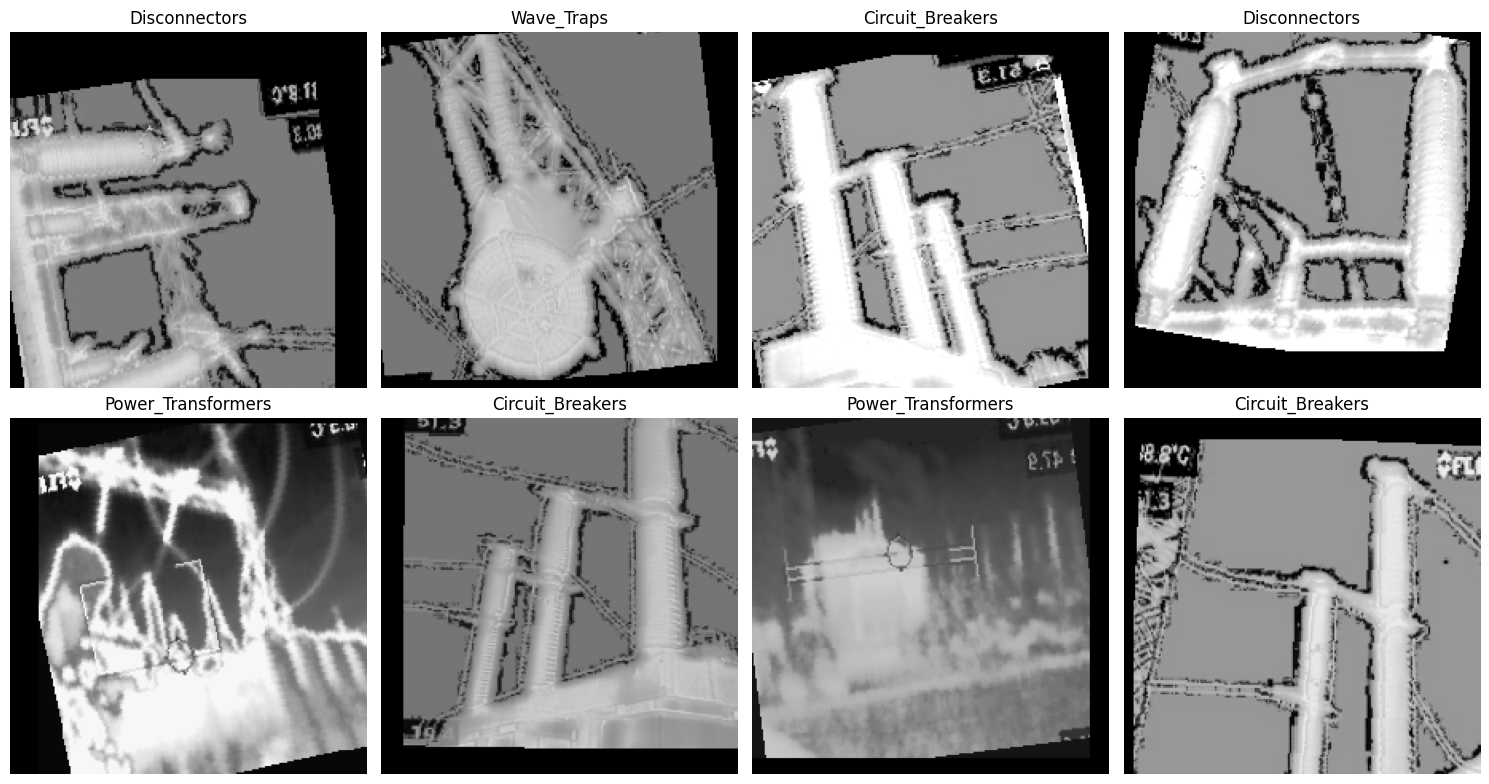

In [7]:
# Obtener un batch de imágenes
images, labels = next(iter(train_loader))

# Mostrar algunas imágenes
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i in range(8):
    # Desnormalizar imagen
    img = images[i].permute(1, 2, 0).numpy()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = std * img + mean
    img = img.clip(0, 1)
    
    axes[i].imshow(img)
    axes[i].set_title(f'{class_names[labels[i]]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 5. Crear Modelo

In [8]:
# Crear modelo
model = get_model(
    model_type=MODEL_TYPE,
    num_classes=len(class_names),
    pretrained=PRETRAINED,
    freeze_backbone=FREEZE_BACKBONE
)

# Contar parámetros
total_params, trainable_params = count_parameters(model)
print(f"Model: {MODEL_TYPE}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/santiagovasquez/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]



INFO - Loaded ResNet-50 with ImageNet pre-trained weights
INFO - Modified ResNet-50 classifier head for 5 classes
Model: resnet50
Total parameters: 24,559,685
Trainable parameters: 24,559,685
Frozen parameters: 0
INFO - Modified ResNet-50 classifier head for 5 classes
Model: resnet50
Total parameters: 24,559,685
Trainable parameters: 24,559,685
Frozen parameters: 0


## 6. Configurar Optimizador y Scheduler

In [9]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

# Optimizador
optimizer = Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

print(f"Optimizer: Adam")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Scheduler: StepLR (step_size=10, gamma=0.1)")

Optimizer: Adam
Learning rate: 0.001
Weight decay: 0.0001
Scheduler: StepLR (step_size=10, gamma=0.1)


## 7. Crear Trainer

In [10]:
# Crear trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    class_names=class_names,
    optimizer=optimizer,
    scheduler=scheduler,
    checkpoint_dir=CHECKPOINT_DIR,
    log_interval=10
)

print(f"Trainer created")
print(f"Checkpoint directory: {CHECKPOINT_DIR}")

INFO - Using device: cuda
Trainer created
Checkpoint directory: models/equipment_classification/resnet50
Trainer created
Checkpoint directory: models/equipment_classification/resnet50


## 8. Entrenar Modelo

In [11]:
# Entrenar
history = trainer.train(
    num_epochs=NUM_EPOCHS,
    early_stopping_patience=EARLY_STOPPING,
    save_best_only=True
)

INFO - Starting training for 50 epochs
INFO - Training samples: 627
INFO - Validation samples: 179
INFO - 
Epoch 1/50
INFO - --------------------------------------------------
INFO - Training samples: 627
INFO - Validation samples: 179
INFO - 
Epoch 1/50
INFO - --------------------------------------------------
INFO -   Batch [10/20] Loss: 1.0197
INFO -   Batch [10/20] Loss: 1.0197
INFO -   Batch [20/20] Loss: 0.5689
INFO -   Batch [20/20] Loss: 0.5689
INFO - Train Loss: 0.7977, Train Acc: 0.7321
INFO - Train Loss: 0.7977, Train Acc: 0.7321
INFO - Val Loss: 1.4784, Val Acc: 0.7095
INFO - 
Per-class metrics:
INFO -   Circuit_Breakers: P=0.500, R=0.024, F1=0.045, N=42
INFO -   Disconnectors: P=0.690, R=0.967, F1=0.806, N=30
INFO -   Power_Transformers: P=0.881, R=0.881, F1=0.881, N=42
INFO -   Surge_Arresters: P=0.868, R=0.892, F1=0.880, N=37
INFO -   Wave_Traps: P=0.491, R=0.964, F1=0.651, N=28
INFO - Validation accuracy improved from 0.0000 to 0.7095
INFO - Val Loss: 1.4784, Val Acc: 0

## 9. Visualizar Resultados de Entrenamiento

In [12]:
# Graficar historial de entrenamiento
trainer.plot_history()
plt.show()

## 10. Evaluar en Conjunto de Test

In [13]:
# Cambiar el data loader de validación al de test
trainer.val_loader = test_loader

# Evaluar
test_loss, test_acc, test_metrics = trainer.validate()

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"\nPer-class metrics:")

for class_name, metrics in test_metrics['per_class'].items():
    print(f"  {class_name}:")
    print(f"    Precision: {metrics['precision']:.3f}")
    print(f"    Recall: {metrics['recall']:.3f}")
    print(f"    F1-score: {metrics['f1']:.3f}")
    print(f"    Support: {metrics['support']}")

Test Loss: 0.0142
Test Accuracy: 1.0000

Per-class metrics:
  Circuit_Breakers:
    Precision: 1.000
    Recall: 1.000
    F1-score: 1.000
    Support: 11
  Disconnectors:
    Precision: 1.000
    Recall: 1.000
    F1-score: 1.000
    Support: 27
  Power_Transformers:
    Precision: 1.000
    Recall: 1.000
    F1-score: 1.000
    Support: 11
  Surge_Arresters:
    Precision: 1.000
    Recall: 1.000
    F1-score: 1.000
    Support: 20
  Wave_Traps:
    Precision: 1.000
    Recall: 1.000
    F1-score: 1.000
    Support: 20


## 11. Visualizar Matriz de Confusión

In [14]:
# Graficar matriz de confusión
trainer.plot_confusion_matrix(test_metrics)
plt.show()

## 12. Guardar Métricas

In [15]:
import json
from pathlib import Path

# Guardar métricas de test
metrics_path = Path(CHECKPOINT_DIR) / 'test_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(test_metrics, f, indent=2)

print(f"Test metrics saved to {metrics_path}")

Test metrics saved to models/equipment_classification/resnet50/test_metrics.json


## 13. Inferencia en Nuevas Imágenes

In [16]:
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

# Definir transform para inferencia
transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def predict_image(image_path, model, class_names, device, top_k=3):
    """Predict class for a single image."""
    # Cargar imagen
    image = Image.open(image_path).convert('RGB')
    
    # Aplicar transform
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predicción
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)[0]
    
    # Top-k predicciones
    top_probs, top_indices = torch.topk(probabilities, min(top_k, len(class_names)))
    
    print(f"\nImage: {image_path}")
    print(f"Top {top_k} predictions:")
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices), 1):
        print(f"  {i}. {class_names[idx]}: {prob*100:.2f}%")
    
    # Mostrar imagen
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f"Prediction: {class_names[top_indices[0]]} ({top_probs[0]*100:.2f}%)")
    plt.axis('off')
    plt.show()
    
    return class_names[top_indices[0]], float(top_probs[0])

# Ejemplo de uso (ajusta el path a una imagen real)
# image_path = 'path/to/your/image.jpg'
# device = next(model.parameters()).device
# predicted_class, confidence = predict_image(image_path, model, class_names, device)

## 14. Cargar Modelo Guardado

In [ ]:
# Para cargar el modelo en una sesión futura
def load_trained_model(checkpoint_path, device=None):
    """Load a trained model from checkpoint."""
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    device = torch.device(device)
    
    # Cargar checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Obtener información del modelo
    class_names = checkpoint['class_names']
    num_classes = len(class_names)
    
    # Determinar tipo de modelo
    if 'inception' in checkpoint_path.lower():
        model_type = 'inception_v3'
    else:
        model_type = 'resnet50'
    
    # Crear y cargar modelo
    model = get_model(model_type, num_classes, pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"Loaded {model_type} model")
    print(f"Best validation accuracy: {checkpoint['best_val_acc']:.4f}")
    
    return model, class_names, device

# Ejemplo de uso
# checkpoint_path = 'models/equipment_classification/resnet50/best_model.pth'
# model, class_names, device = load_trained_model(checkpoint_path)

: 

## Conclusión

Este notebook demostró:
1. Cómo cargar y preparar datos para clasificación de equipos
2. Cómo crear y configurar modelos ResNet-50 e Inception-v3
3. Cómo entrenar modelos con early stopping y checkpointing
4. Cómo evaluar modelos y visualizar resultados
5. Cómo realizar inferencia en nuevas imágenes

### Próximos Pasos
- Experimentar con diferentes hiperparámetros
- Probar fine-tuning en dos fases (congelar/descongelar backbone)
- Implementar ensemble de múltiples modelos
- Aplicar a tareas de hotspot detection/classification